In [16]:
import math, re, os, random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.backend as K
# from tensorflow_addons.metrics import F1Score
from tensorflow.keras import layers as L
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tf_applications
import efficientnet.tfkeras as efn
print("TF version " + tf.__version__)

TF version 2.15.0


In [17]:
# 检查 TensorFlow 是否支持 GPU
print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

# 获取 GPU 设备信息
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU available.")

TensorFlow version: 2.15.0
Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [18]:
AUTO = tf.data.AUTOTUNE
strategy = tf.distribute.get_strategy()

SEED = 77

IMAGE_SIZE = [224, 224]
EPOCHS = 30
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

DN = 201 #DenseNet 121,169,201

EFN = 7 # 0, 1, 2, 3, 4, 5, 6 or 7
EFN_WEIGHTS = 'noisy-student' # 'imagenet' or 'noisy-student'

In [19]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
set_seed(SEED)

In [20]:
DATA_PATH  = os.getcwd()
TRAINING_FILENAMES = tf.io.gfile.glob(DATA_PATH + '/train_images/*.jpg')
TEST_FILENAMES = tf.io.gfile.glob(DATA_PATH + '/test_images/*.jpg')
TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')
TEST_CSV = os.path.join(DATA_PATH, 'test.csv')

In [21]:
def load_csv():
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
    labels = train_df['label'].unique().tolist()
    label_to_idx = {label: idx for idx, label in enumerate(labels)}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    return train_df, test_df, label_to_idx, idx_to_label

In [22]:
# 修改数据加载部分
train_df, test_df, label_to_idx, idx_to_label = load_csv()
# 划分训练集和验证集
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df['label'])
NUM_TRAINING_IMAGES = train_df.shape[0]
NUM_VALIDATION_IMAGES = val_df.shape[0]
NUM_TEST_IMAGES = test_df.shape[0]
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
NUM_CLASSES = len(label_to_idx)
print(f"Number of training images: {NUM_TRAINING_IMAGES}")
print(f"Number of validation images: {NUM_VALIDATION_IMAGES}")
print(f"Number of test images: {NUM_TEST_IMAGES}")
print(f"Number of classes: {NUM_CLASSES}")

Number of training images: 2599
Number of validation images: 650
Number of test images: 3250
Number of classes: 75


## 数据增强
第一种数据增强方案是**transform**，让图像出现旋转收放缩的增强；

第二种数据增强方案是**random erasing**，让图像出现随机黑色方块；

第二种数据增强方案中的p参数确定数据有多少比例产生黑色方块，比例太少不足以让模型产生较好的泛化能力，比例太多不足以训练出一个完善的模型，存在一个trade-off的问题。

In [23]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [24]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    # return tf.reshape(d,[DIM,DIM,3]),label
    return tf.cond(tf.random.uniform([], 0, 1) > 0.8, lambda: tf.cast(image, image.dtype), lambda:  tf.cast(tf.reshape(d,[DIM,DIM,3]), image.dtype)),label

In [25]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.35):  #双模型最佳参数p=0.35
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

In [26]:
def decode_image(image_path, label):
    # 读取图片文件
    image = tf.io.read_file(image_path)
    # 使用tf.image.decode_jpeg进行解码
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # 将图片转换为[0, 1]范围的浮点数
    # image = tf.image.resize(image, IMAGE_SIZE)  # 调整图片尺寸
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    # 将标签转换为整数
    label = tf.cast(label, tf.int64)
    return image, label

def onehot(image, label):
    return image, tf.one_hot(label, NUM_CLASSES)

def load_dataset(filenames, labels, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed
    # 创建dataset
    filenames = [str(DATA_PATH + '/train_images/' + fname) for fname in filenames]
    labels = [label_to_idx[label] for label in labels]
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)

    return dataset
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    
    return image, label

def data_augment_alpha(image, label):
    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image,p=0.7)
    
    return image, label
def data_hflip(image):
    image = tf.image.flip_left_right(image)
    return image
def get_training_dataset(data,do_onehot=False):
    dataset = load_dataset(data['filename'],data['label'])
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(1800, reshuffle_each_iteration=True) #2048
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset
def get_validation_dataset(data,ordered=False, do_onehot=False):
    dataset = load_dataset(data['filename'],data['label'],ordered=ordered)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset_alpha(data,ordered=False, do_onehot=False):
    dataset = load_dataset(data['filename'],data['label'],ordered=ordered)
    dataset = dataset.map(data_augment_alpha, num_parallel_calls=AUTO)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


In [27]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset(train_df).take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset(val_df).take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())

Training data shapes:
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
Training data label examples: [10 61  5 32 22 40 47  3 13 12 11 72 28 21 66 17 18 72 54 58 15 65  2 69
 59 11 57 66 38 21 30 71]
Validation data shapes:
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
Validation data label examples: [11 16 68 23 29 60 28 72 17 38 68 66  2  8 73 23 39 38 18 56 63 61 71 17
 41 73 42 10  0 13 10 72]


# 数据可视化


In [28]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    return numpy_images, numpy_labels

# def title_from_label_and_target(label, correct_label):
#     if correct_label is None:
#         return CLASSES[label], True
#     correct = (label == correct_label)
#     return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
#                                 CLASSES[correct_label] if not correct else ''), correct

def display_one_butterfly(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)  
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = idx_to_label[label]
        correct = True
        # if predictions is not None:
        #     title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_butterfly(image, title, subplot,titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [29]:
training_dataset = get_training_dataset(train_df)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)


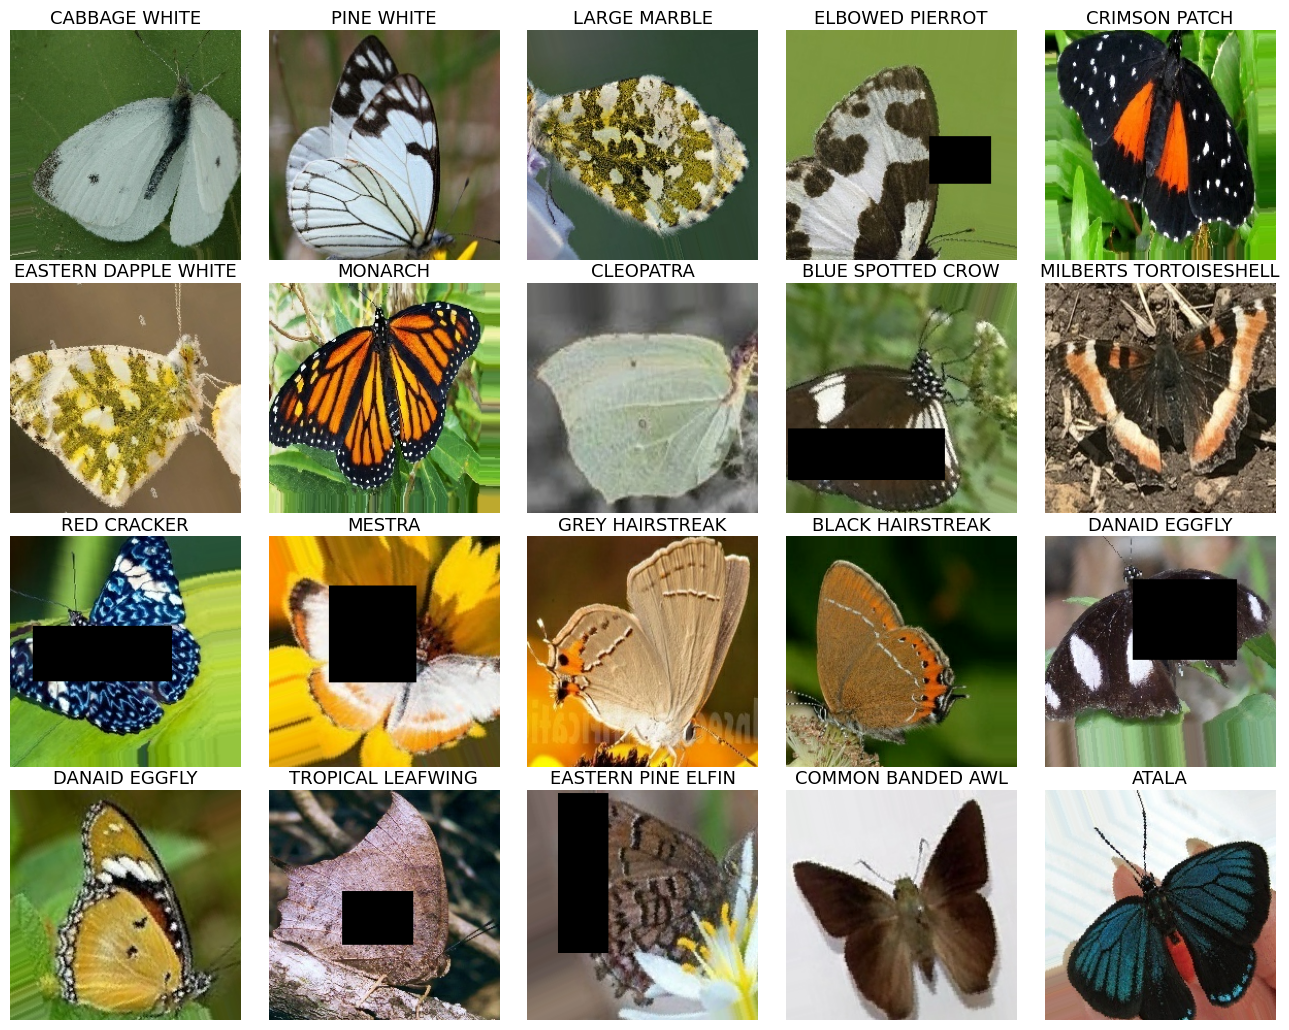

In [30]:
display_batch_of_images(next(train_batch)) #重复运行可以看到不同的数据展示

# 学习率方案设置
LR_RAMPUP_EPOCHS参数表示从LR_MIN到LR_MAX需要的epoch数目；

LR_SUSTAIN_EPOCHS参数表示学习率达到LR_MAX持续的epoch数目；

LR_EXP_DECAY参数表示的学习率在减小的衰退指数，值越大，衰减的越慢；

In [31]:
def get_lr_callback(plot_schedule=False):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5  #mixup 8   standard 5
    LR_SUSTAIN_EPOCHS = 3
    LR_EXP_DECAY = .85
    def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
        return lr
    
    if plot_schedule:
        rng = [i for i in range(25 if EPOCHS < 25 else EPOCHS)]
        y = [lrfn(x) for x in rng]
        plt.plot(rng, y)

    return callbacks.LearningRateScheduler(lrfn, verbose=0)

In [32]:
def get_lr_callback_dense(plot_schedule=False):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 10  #mixup 8   standard 5
    LR_SUSTAIN_EPOCHS = 5
    LR_EXP_DECAY = .9
    def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
        return lr
    
    if plot_schedule:
        rng = [i for i in range(25 if EPOCHS < 25 else EPOCHS)]
        y = [lrfn(x) for x in rng]
        plt.plot(rng, y)

    return callbacks.LearningRateScheduler(lrfn, verbose=0)

# 模型训练
&emsp;&emsp;模型这部分大家在群里面讨论了很多，主要还是分成两个流派，T派（transform模型）和C派（convolution模型），本人在比赛前半段时间一直在研究swin和vision transform，性能只能停留在0.94，看到大家都上到0.95，觉得方向不对，转向C派，尝试了一些模型，最后确定efficient7和densenet201作为ensemble的子模型，这里有同学说densenet模型很容易过拟合，验证准确率上去，但是测试效果不好，我也发现了这个问题，在训练的过程中关注loss情况，loss降幅不大达到训练目标可以早停退出，避免过拟合。

&emsp;&emsp;另外一个显著增加测试准确率的方法就是交叉验证，在这里我采用的是五折交叉验证。

In [33]:
def load_and_fit_models(model_name,myepoch=50,mypatience=8,print_summary=False):
    train_df, test_df, label_to_idx, idx_to_label = load_csv()
    models = []
    kfold = KFold(5, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(train_df)):
        print(); print('#'*25)
        print('### FOLD',f+1)
        print('#'*25)
        with strategy.scope():
            if model_name == 'efficientnet':
                base_model = getattr(efn, f'EfficientNetB{EFN}')(
                            weights=None, include_top=False,
                            pooling='avg', input_shape=(*IMAGE_SIZE, 3))
                
                base_model.load_weights(str(DATA_PATH + f'/efficientnet{EFN}.h5'))
                # base_model.load_weights(f'/nas-data/dengyipin/the-1st-data-tech-alchemist-cup/efficientnet{EFN}.h5')
                model = tf.keras.Sequential([ 
                base_model,           
                L.Dense(NUM_CLASSES, activation='softmax')
                ])
            elif model_name == 'densenet':
                base_model = getattr(tf_applications,f'DenseNet{DN}')(
                    weights=None , include_top=False,
                    pooling='avg', input_shape=(*IMAGE_SIZE, 3)
                )
                base_model.load_weights(str(DATA_PATH + f'/DenseNet{DN}.h5'))
                # base_model.load_weights(f'/nas-data/dengyipin/the-1st-data-tech-alchemist-cup/DenseNet{DN}.h5')
                model = tf.keras.Sequential([ 
                base_model,           
                L.Dense(NUM_CLASSES, activation='softmax')
                ])
                
            model.compile(
                optimizer='adam',
                loss = 'categorical_crossentropy',
                # metrics=[tf.keras.metrics.F1Score(NUM_CLASSES, average='macro')]
                metrics=[F1Score(NUM_CLASSES, average='macro')]
            )
        if print_summary:
            model.summary()
            
        os.makedirs('checkpoints', exist_ok=True)
        
        lr_callback = get_lr_callback()
        chk_callback = callbacks.ModelCheckpoint(f'checkpoints/{model_name}_best_{f}',
                        save_weights_only=True, monitor='val_f1_score',
                        mode='max', save_best_only=True, verbose=1)
        early_stopping = callbacks.EarlyStopping(monitor='val_f1_score', patience=mypatience, mode='max',restore_best_weights=True)
        
        _ = model.fit(get_training_dataset(train_df.iloc[trn_ind],do_onehot=True), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=myepoch,#EPOCHS, 
                    validation_data=get_validation_dataset(train_df.iloc[val_ind],do_onehot=True),
                    callbacks=[lr_callback, chk_callback,early_stopping], 
                    verbose=2)
        model.load_weights(f'checkpoints/{model_name}_best_{f}')
        models.append(model)

    return models

In [34]:
def load_and_fit_models2(model_name1,model_name2,myepoch=50,mypatience=8,print_summary=False):
    train_df, test_df, label_to_idx, idx_to_label = load_csv()
    models1 = []
    models2 = []
    kfold = KFold(5, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(train_df)):
        print(); print('#'*25)
        print('### FOLD',f+1)
        print('#'*25)
        with strategy.scope():
            if model_name1 == 'efficientnet':
                base_model = getattr(efn, f'EfficientNetB{EFN}')(
                            weights=None, include_top=False,
                            pooling='avg', input_shape=(*IMAGE_SIZE, 3))
                base_model.load_weights(str(DATA_PATH + f'/efficientnet{EFN}.h5'))
                model1 = tf.keras.Sequential([ 
                base_model,           
                L.Dense(NUM_CLASSES, activation='softmax')
                ])
            elif model_name1 == 'densenet':
                base_model = getattr(tf_applications,f'DenseNet{DN}')(
                    weights=None , include_top=False,
                    pooling='avg', input_shape=(*IMAGE_SIZE, 3)
                )
                base_model.load_weights(str(DATA_PATH + f'/DenseNet{DN}.h5'))
                model1 = tf.keras.Sequential([ 
                base_model,           
                L.Dense(NUM_CLASSES, activation='softmax')
                ])


            if model_name2 == 'efficientnet':
                base_model = getattr(efn, f'EfficientNetB{EFN}')(
                            weights=None, include_top=False,
                            pooling='avg', input_shape=(*IMAGE_SIZE, 3))
                base_model.load_weights(str(DATA_PATH + f'/efficientnet{EFN}.h5'))
                model2 = tf.keras.Sequential([ 
                base_model,           
                L.Dense(NUM_CLASSES, activation='softmax')
                ])
            elif model_name2 == 'densenet':
                base_model = getattr(tf_applications,f'DenseNet{DN}')(
                    weights=None , include_top=False,
                    pooling='avg', input_shape=(*IMAGE_SIZE, 3)
                )
                base_model.load_weights(str(DATA_PATH + f'/DenseNet{DN}.h5'))
                model2 = tf.keras.Sequential([ 
                base_model,           
                L.Dense(NUM_CLASSES, activation='softmax')
                ])

            model1.compile(
                optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=[F1Score(NUM_CLASSES, average='macro')]
            )
            model2.compile(
                optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=[F1Score(NUM_CLASSES, average='macro')]
            )
        if print_summary:
            model1.summary()
            model2.summary()
            
        os.makedirs('checkpoints', exist_ok=True)
        lr_callback = get_lr_callback()
        early_stopping = callbacks.EarlyStopping(monitor='val_f1_score', patience=mypatience, mode='max',restore_best_weights=True)
        print(); print('Training model1')
        
        chk_callback = callbacks.ModelCheckpoint(f'checkpoints/{model_name1}_best_{f}',
                        save_weights_only=True, monitor='val_f1_score',
                        mode='max', save_best_only=True, verbose=1)
        lr_callback = get_lr_callback()
        _ = model1.fit(get_training_dataset(train_df.iloc[trn_ind],do_onehot=True), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=myepoch,#EPOCHS, 
                    validation_data=get_validation_dataset(train_df.iloc[val_ind],do_onehot=True),
                    callbacks=[lr_callback, chk_callback,early_stopping], #, log_callback
                    verbose=2)
        
        print(); print('Training model2')
        chk_callback = callbacks.ModelCheckpoint(f'checkpoints/{model_name2}_best_{f}',
                        save_weights_only=True, monitor='val_f1_score',
                        mode='max', save_best_only=True, verbose=1)
        lr_callback_dense = get_lr_callback_dense()
        _ = model2.fit(get_training_dataset(train_df.iloc[trn_ind],do_onehot=True), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=myepoch,#EPOCHS, 
                    validation_data=get_validation_dataset(train_df.iloc[val_ind],do_onehot=True),
                    callbacks=[lr_callback_dense, chk_callback,early_stopping], #, log_callback
                    verbose=2)
        model1.load_weights(f'checkpoints/{model_name1}_best_{f}')
        model2.load_weights(f'checkpoints/{model_name2}_best_{f}')
        models1.append(model1)
        models2.append(model2)

    return models1,models2

In [35]:
# models = load_and_fit_models('efficientnet',myepoch=70,mypatience=25)

In [36]:
# models1,models2 = load_and_fit_models2('efficientnet','densenet',myepoch=80,mypatience=30)

In [37]:
def predict(dataset, model):
    print('Calculating predictions...')
    preds = model.predict(dataset,verbose=0)
    return preds

def decode_image_test(image_path):
    # 读取图片文件
    image = tf.io.read_file(image_path)
    # 使用tf.image.decode_jpeg进行解码
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # 将图片转换为[0, 1]范围的浮点数
    # image = tf.image.resize(image, IMAGE_SIZE)  # 调整图片尺寸
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    return image
def get_test_dataset(filenames,ordered=False, augmented=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed
    # 创建dataset
    filenames = [str(DATA_PATH + '/test_images/' + fname) for fname in filenames]
    dataset = tf.data.Dataset.from_tensor_slices((filenames))
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(decode_image_test, num_parallel_calls=AUTO)
    if augmented:
        dataset = dataset.map(data_hflip, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# 模型推理
&emsp;&emsp;因为是两个模型ensemble，需要设置一个alpha权重参数，这里写一个找最优alpha的脚本，值得注意的是需要将验证集进一步增强处理一下再用，因为交叉验证已经将验证集算作训练使用过了，找一个最优参数需要花费3小时，对，没听错三小时，就不用运行下面两个cell了，0.45~0.48都不错。

In [38]:
# def find_best_alpha_cross(valid_dataset):
#     images_ds = valid_dataset.map(lambda image, label: image)
#     labels_ds = valid_dataset.map(lambda image, label: label).unbatch()
#     y_true = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch

#     scores = []
#     for alpha in np.linspace(0,1,100):
#         print(f'Calculating alpha {alpha}...')
#         possibility = []
#         for i in range(5):
#             base_model = getattr(efn,f'EfficientNetB{EFN}')(
#                         weights=None , include_top=False,
#                         pooling='avg', input_shape=(*IMAGE_SIZE, 3)
#                     )
#             model = tf.keras.Sequential([ 
#                 base_model,           
#                 L.Dense(NUM_CLASSES, activation='softmax')
#             ])
#             status = model.load_weights(f'checkpoints/efficientnet_best_{i}')
#             status.expect_partial()
#             preds_m1 = model.predict(images_ds)

#             base_model = getattr(tf_applications,f'DenseNet{DN}')(
#                         weights=None , include_top=False,
#                         pooling='avg', input_shape=(*IMAGE_SIZE, 3)
#                     )
#             model = tf.keras.Sequential([ 
#                 base_model,           
#                 L.Dense(NUM_CLASSES, activation='softmax')
#             ])
#             status = model.load_weights(f'checkpoints/densenet_best_{i}')
#             status.expect_partial()
#             preds_m2 = model.predict(images_ds)
            
#             preds_mix = alpha*preds_m1 + (1-alpha)*preds_m2
#             possibility.append(preds_mix)
#         preds = np.mean(possibility, axis=0)

#         preds = np.argmax(preds, axis=1)
#         score = f1_score(y_true, preds, labels=range(NUM_CLASSES), average='macro')

#         scores.append(score)
#         print(f'score:{score}')

#     best_alpha = np.argmax(scores)/100
#     return best_alpha

In [39]:
# valid_ds = get_validation_dataset_alpha(val_df,ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
# alpha = find_best_alpha_cross(valid_ds)
# print(f'Best alpha is {alpha}')

In [40]:
SUBMISSION_FILE = str(DATA_PATH+'/submission.csv')
print('Generating submission file...')
possibility = []
alpha = 0.46
for i in range(5):
    base_model = getattr(efn,f'EfficientNetB{EFN}')(
                weights=None , include_top=False,
                pooling='avg', input_shape=(*IMAGE_SIZE, 3)
            )
    model = tf.keras.Sequential([ 
        base_model,           
        L.Dense(NUM_CLASSES, activation='softmax')
    ])
    status = model.load_weights(str(DATA_PATH + f'checkpoints/efficientnet_best_{i}'))
    status.expect_partial()
    test_ds_1 = get_test_dataset(test_df['filename'],ordered=True, augmented=False)
    preds_m1 = predict(test_ds_1, model)


    base_model = getattr(tf_applications,f'DenseNet{DN}')(
                weights=None , include_top=False,
                pooling='avg', input_shape=(*IMAGE_SIZE, 3)
            )
    model = tf.keras.Sequential([ 
        base_model,           
        L.Dense(NUM_CLASSES, activation='softmax')
    ])
    status = model.load_weights(str(DATA_PATH + f'checkpoints/densenet_best_{i}'))
    status.expect_partial()
    test_ds_1 = get_test_dataset(test_df['filename'],ordered=True, augmented=False)
    preds_m2 = predict(test_ds_1, model)

    preds_mix = alpha*preds_m1 + (1-alpha)*preds_m2
    possibility.append(preds_mix)
preds = np.mean(possibility, axis=0)
preds = np.argmax(preds, axis=1)
pred_labels = [idx_to_label[pred] for pred in preds]
predictions = []
for filename, label in zip(test_df['filename'], pred_labels):
    predictions.append((filename, label))
submission_df = pd.DataFrame(predictions, columns=['filename', 'label'])
submission_df.to_csv(SUBMISSION_FILE, index=False)

Generating submission file...
Calculating predictions...
Calculating predictions...
Calculating predictions...
Calculating predictions...
Calculating predictions...
Calculating predictions...
Calculating predictions...
Calculating predictions...
Calculating predictions...
Calculating predictions...
